# Imports and dependencies

This is the commands used to set up the proper configuration that works:
```bash
python -m venv bnn_env
.\bnn_env\Scripts\activate
pip install pyro-ppl torchvision torch numpy matplotlib imageio ipykernel
pip install --upgrade jupyter ipywidgets
```
See the dependencies in `requirements.txt` for specific versions

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from imageio import imread

import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
%matplotlib inline

import os
from datetime import datetime
import pandas as pd

from collections import Counter

# Data Preparation

In [3]:
def get_split_MNIST(train_val_split = 0.8):
    
        transform = transforms.Compose([transforms.ToTensor()])

        full_train_dataset = datasets.MNIST(root='mnist-data/', train=True, download=True, transform=transform)

        train_size = int(train_val_split * len(full_train_dataset))
        val_size = len(full_train_dataset) - train_size

        train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
        test_dataset = datasets.MNIST(root='mnist-data/', train=False, transform=transform)

        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

        return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_split_MNIST()

100%|██████████| 9.91M/9.91M [00:10<00:00, 903kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 56.0kB/s]
100%|██████████| 1.65M/1.65M [00:05<00:00, 307kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.00MB/s]


# Model Creation

Define a `NN` with a single hidden layer the same size as the input layer

In [4]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output
net = NN(28*28, 28*28, 10)
log_softmax = nn.LogSoftmax(dim=1)
softplus = torch.nn.Softplus()

def model(x_data, y_data):

    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight)).to_event(2)
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias)).to_event(1)

    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight)).to_event(2)
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias)).to_event(1)

    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()

    lhat = log_softmax(lifted_reg_model(x_data))

    pyro.sample("obs", Categorical(logits=lhat).to_event(1), obs=y_data)

def guide(x_data, y_data):

    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior.to_event(2), 'fc1.bias': fc1b_prior.to_event(1), 'out.weight': outw_prior.to_event(2), 'out.bias': outb_prior.to_event(1)}

    lifted_module = pyro.random_module("module", net, priors)

    return lifted_module()

optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

# Training

/home/dj/bnn_env/lib/python3.10/site-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(


Epoch 1, Batch 0, Loss: 626036.9183
Epoch 1, Batch 100, Loss: 313680.6369
Epoch 1, Batch 200, Loss: 182671.6710
Epoch 1, Batch 300, Loss: 120814.8052
Epoch 1: Train Loss = 1903.2343, Val Loss = 720.9062
Epoch 2, Batch 0, Loss: 90675.6601
Epoch 2, Batch 100, Loss: 65895.6584
Epoch 2, Batch 200, Loss: 51036.6738
Epoch 2, Batch 300, Loss: 38661.6899
Epoch 2: Train Loss = 431.2412, Val Loss = 257.0018
Epoch 3, Batch 0, Loss: 31917.2317
Epoch 3, Batch 100, Loss: 27085.5596
Epoch 3, Batch 200, Loss: 21086.4179
Epoch 3, Batch 300, Loss: 17956.2952
Epoch 3: Train Loss = 182.6926, Val Loss = 133.1784
Epoch 4, Batch 0, Loss: 19404.2333
Epoch 4, Batch 100, Loss: 14543.3937
Epoch 4, Batch 200, Loss: 13855.8520
Epoch 4, Batch 300, Loss: 15261.0360
Epoch 4: Train Loss = 111.1360, Val Loss = 95.2835
Epoch 5, Batch 0, Loss: 12027.3422
Epoch 5, Batch 100, Loss: 12859.9753
Epoch 5, Batch 200, Loss: 11504.0306
Epoch 5, Batch 300, Loss: 10352.3517
Epoch 5: Train Loss = 86.8054, Val Loss = 81.1445
Epoch 6,

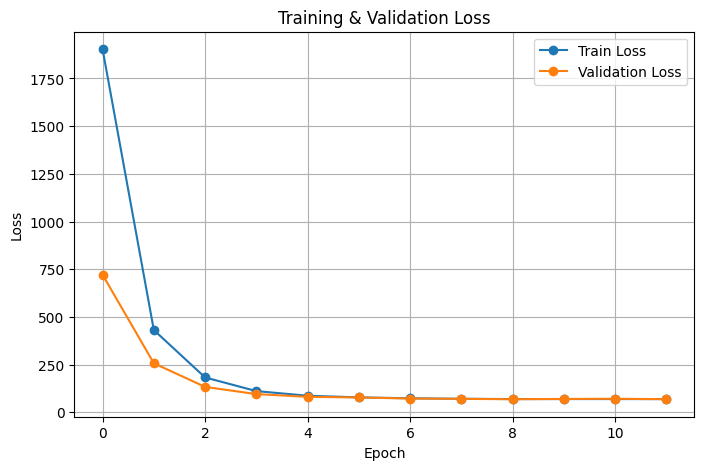

In [5]:
num_epochs = 30
patience = 3

train_losses = []   
val_losses = []
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    train_loss = 0

    # Training loop
    for batch_id, data in enumerate(train_loader):
        loss = svi.step(data[0].view(-1, 28 * 28), data[1])
        train_loss += loss

        # Print progress every 100 batches
        if batch_id % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_id}, Loss: {loss:.4f}")

    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = train_loss / normalizer_train
    train_losses.append(total_epoch_loss_train)

    # Validation loop
    val_loss = 0
    for batch_id, data in enumerate(val_loader):
        val_loss += svi.evaluate_loss(data[0].view(-1, 28 * 28), data[1])

    normalizer_val = len(val_loader.dataset)
    total_epoch_loss_val = val_loss / normalizer_val
    val_losses.append(total_epoch_loss_val)

    print(f"Epoch {epoch+1}: Train Loss = {total_epoch_loss_train:.4f}, Val Loss = {total_epoch_loss_val:.4f}")


    if total_epoch_loss_val < best_val_loss:
        best_val_loss = total_epoch_loss_val
        epochs_no_improve = 0  
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(8,5))
    plt.plot(range(len(train_losses)), train_losses, label="Train Loss", marker='o')
    plt.plot(range(len(val_losses)), val_losses, label="Validation Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

plot_loss(train_losses, val_losses)


# Store

In [6]:
def save_checkpoint(model, model_dir='./models'):
    # Generate the current date and time string
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    
    # Create a filename for the checkpoint with the current date and time
    filename = f'{model_dir}/bnn_mnist_{current_time}.pth'
    
    # Create a dictionary to store both the model and guide state dicts
    checkpoint = {
        'model_state_dict': model.state_dict(),  # Save the model state dict
        'guide_state_dict': {name: param.data.cpu().numpy() for name, param in pyro.get_param_store().items()}  # Save Pyro parameters
    }
    
    # Save the checkpoint to a file
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved to {filename}")

def load_checkpoint(model, model_dir='./models'):
    # Get the most recent file based on modified time
    model_files = [f for f in os.listdir(model_dir) if f.endswith(".pth")]
    if not model_files:
        raise FileNotFoundError(f"No model files found in '{model_dir}'.")

    most_recent_file = max(
        [os.path.join(model_dir, f) for f in model_files], key=os.path.getmtime
    )
    print(f"Loading the most recent model: {most_recent_file}")

    # Load the checkpoint
    checkpoint = torch.load(most_recent_file, weights_only=False)

    # Load model state_dict with strict=False to handle size mismatch
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)

    # Load guide state_dict (Pyro parameters)
    for name, param in checkpoint['guide_state_dict'].items():
        pyro.get_param_store()[name].data = torch.tensor(param)
    
    # Return the model after loading
    model.eval()  # Set to evaluation mode
    return model


## Save the Model

In [8]:
save_checkpoint(net, './models')

Checkpoint saved to ./models/bnn_mnist_2025-05-31_21-40-22.pth


## Load the Model

In [9]:
net_loaded = NN(28*28, 28*28, 10)
net_loaded = load_checkpoint(net_loaded, './models')

Loading the most recent model: ./models/bnn_mnist_2025-05-31_21-40-22.pth


# Testing

In [10]:

def mode_freq(predictions):
    counts = Counter(predictions)
    sorted_counts = sorted(counts.values(), reverse=True)
    
    # Get the 1st, 2nd, and 3rd mode frequencies
    first_mode_freq = sorted_counts[0]
    second_mode_freq = sorted_counts[1] if len(sorted_counts) > 1 else 0
    third_mode_freq = sorted_counts[2] if len(sorted_counts) > 2 else 0
    
    # Number of unique numbers (distinct modes)
    num_unique = len(counts)
    
    # print(f"1st Mode Frequency: {first_mode_freq/ len(predictions)}")
    # print(f"2nd Mode Frequency: {second_mode_freq/ len(predictions)}")
    # print(f"3rd Mode Frequency: {third_mode_freq/ len(predictions)}")
    # print(f"Number of unique numbers: {num_unique}")
    
    return num_unique, first_mode_freq / len(predictions), second_mode_freq / len(predictions), third_mode_freq / len(predictions)

def predict(x_batch, num_samples):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x_batch).data for model in sampled_models]  # Process whole batch
    predictions = torch.stack(yhats)  # Shape: (num_samples, batch_size, num_classes)
    
    preds = np.argmax(predictions.numpy(), axis=2)  # Get predicted class for each sample
    final_preds = np.array([Counter(preds[:, i]).most_common(1)[0][0] for i in range(preds.shape[1])])  
    mode_freqs = np.array([mode_freq(preds[:, i]) for i in range(preds.shape[1])])  

    return final_preds, mode_freqs  # Now returns a single predicted label per image

def test_accuracy(loader, num_samples=10):
    correct = 0
    total = 0
    num_batches = len(loader)
    results = []

    for j, (images, labels) in enumerate(loader):
        batch_size = images.size(0)
        predicted_batch, mode_batch = predict(images.view(batch_size, -1), num_samples)  # Now returns a single value per image

        for i in range(batch_size):
            total += 1
            correct += (predicted_batch[i] == labels[i].item())  # Compare single prediction, not an array
            num_unique, first_mode_freq , second_mode_freq , third_mode_freq  = mode_batch[i]
            results.append({
                "Image_Index": j * loader.batch_size + i,
                "True_Label": labels[i].item(),
                "Predicted_Label": predicted_batch[i],  # No more indexing with [:, i]
                "U": num_unique,
                "FM1": first_mode_freq,
                "FM2": second_mode_freq,
                "FM3": third_mode_freq,
                "C": labels[i].item() == predicted_batch[i]
            })

        # Print progress every 10 batches
        print(f'\rProgress: [{j + 1}/{num_batches}]', end='')

    print(f"\nAccuracy: {100 * correct / total:.2f}%")
    return results

def classify_and_store(results, csv_filename = 'results.csv'):

    df = pd.DataFrame(results)
    df.to_csv(csv_filename, index=False)
    print(f"\nClassification results saved to {csv_filename}")
    
    return df

results = test_accuracy(loader = train_loader)
classify_and_store(results, csv_filename='train.csv')


Progress: [375/375]
Accuracy: 87.00%

Classification results saved to train.csv


,Image_Index,True_Label,Predicted_Label,U,FM1,FM2,FM3,C
0,0,6,6,2.0,0.9,0.1,0.0,True
1,1,4,4,1.0,1.0,0.0,0.0,True
2,2,7,7,4.0,0.6,0.2,0.1,True
3,3,1,5,5.0,0.4,0.3,0.1,False
4,4,7,4,6.0,0.4,0.2,0.1,False
...,...,...,...,...,...,...,...,...
47995,47995,5,8,6.0,0.4,0.2,0.1,False
47996,47996,9,9,2.0,0.9,0.1,0.0,True
47997,47997,5,5,4.0,0.4,0.4,0.1,True
47998,47998,6,6,1.0,1.0,0.0,0.0,True


## Uncertainty Tests

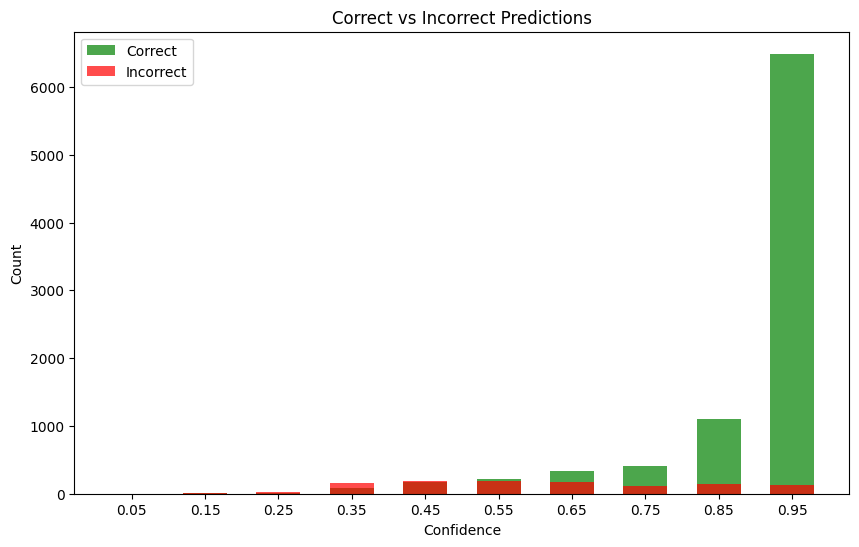

In [11]:
def bar_test(mode_freq = "FM1",csv_filename="train.csv"):

    df = pd.read_csv(csv_filename)
    df["Misclassified"] = df["True_Label"] != df["Predicted_Label"]
    bins = np.arange(0, 1.1, 0.1)  # Bins from 0.0 to 1.0 with width 0.1
    if mode_freq == "U": bins*= 10

    correct_counts = df.loc[~df["Misclassified"], mode_freq].value_counts(bins=bins, sort=False)
    incorrect_counts = df.loc[df["Misclassified"], mode_freq].value_counts(bins=bins, sort=False)
    bin_centers = [str(interval.mid) for interval in correct_counts.index]

    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, correct_counts.values, width=0.6, label="Correct", alpha=0.7, color="green")
    plt.bar(bin_centers, incorrect_counts.values, width=0.6, label="Incorrect", alpha=0.7, color="red")

    # Labels
    plt.xlabel(f"{mode_freq}")
    plt.ylabel("Count")
    plt.title("Correct vs Incorrect Predictions")
    plt.xticks(bin_centers, [f"{float(x):.2f}" for x in bin_centers])
    plt.legend()

    # Show plot
    plt.show()
# bar_test("U")
# bar_test("FM1")
# bar_test("FM2")
# bar_test("FM3")
bar_test("Confidence", csv_filename="test_w_conf.csv")

In [12]:

data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")


# Function to calculate the conditional probability distributions
def calculate_cpd(data):
    cpd = {}
    
    # Group by combinations of (U, FM1, FM2, FM3) and calculate P(C=True)
    for (u, fm1, fm2, fm3), group in data.groupby(['U', 'FM1', 'FM2', 'FM3']):
        c_true_count = group['C'].sum()  # Count how many True labels for this combination
        total_count = group.shape[0]  # Total count of this combination
        cpd[(u, fm1, fm2, fm3)] = c_true_count / total_count if total_count > 0 else 0.0
    
    return cpd
cpd = calculate_cpd(data_train)


In [13]:

def calculate_confidence(data, cpd):
    confidences = []
    
    for _, row in data.iterrows():
        u, fm1, fm2, fm3 = row['U'], row['FM1'], row['FM2'], row['FM3']
        
        # Lookup the conditional probability from the CPD
        prob = cpd.get((u, fm1, fm2, fm3), 0.0)  # Default to 0 if not found
        confidences.append(prob)
    
    return confidences

# Calculate CPD



data_test['Confidence'] = calculate_confidence(data_test, cpd)
data_test.to_csv("test_w_conf.csv", index=False)


def print_classification(data, threshold):
    
    filtered_data = data[(data['Confidence'] >= threshold)]
    correct_data = filtered_data[data['C'] == True]
    accuracy = len(correct_data) / len(filtered_data) if len(filtered_data) > 0 else 0
    proportion = len(filtered_data) / len(data) if len(data) > 0 else 0
    print(f"Threshold: {threshold:.2f} | Accuracy: {accuracy * 100:.4f}% on {proportion * 100:.4f}% of the data")

# Loop through the confidence thresholds from 0.0 to 0.99 with a step of 0.01
for threshold in np.arange(0.0, 1.0, 0.01):
    print_classification(data_test, threshold)


Threshold: 0.00 | Accuracy: 88.4600% on 100.0000% of the data
Threshold: 0.01 | Accuracy: 88.4600% on 100.0000% of the data
Threshold: 0.02 | Accuracy: 88.4600% on 100.0000% of the data
Threshold: 0.03 | Accuracy: 88.4600% on 100.0000% of the data
Threshold: 0.04 | Accuracy: 88.4600% on 100.0000% of the data
Threshold: 0.05 | Accuracy: 88.4600% on 100.0000% of the data
Threshold: 0.06 | Accuracy: 88.4600% on 100.0000% of the data
Threshold: 0.07 | Accuracy: 88.4600% on 100.0000% of the data
Threshold: 0.08 | Accuracy: 88.4600% on 100.0000% of the data
Threshold: 0.09 | Accuracy: 88.4600% on 100.0000% of the data
Threshold: 0.10 | Accuracy: 88.4600% on 100.0000% of the data
Threshold: 0.11 | Accuracy: 88.4600% on 100.0000% of the data
Threshold: 0.12 | Accuracy: 88.4600% on 100.0000% of the data
Threshold: 0.13 | Accuracy: 88.4600% on 100.0000% of the data
Threshold: 0.14 | Accuracy: 88.4600% on 100.0000% of the data
Threshold: 0.15 | Accuracy: 88.4600% on 100.0000% of the data
Threshol

/tmp/ipykernel_95634/239185010.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  correct_data = filtered_data[data['C'] == True]
/tmp/ipykernel_95634/239185010.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  correct_data = filtered_data[data['C'] == True]
/tmp/ipykernel_95634/239185010.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  correct_data = filtered_data[data['C'] == True]
/tmp/ipykernel_95634/239185010.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  correct_data = filtered_data[data['C'] == True]
/tmp/ipykernel_95634/239185010.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  correct_data = filtered_data[data['C'] == True]
/tmp/ipykernel_95634/239185010.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  correct_data = filtered_data[data['C'] == True]
/tmp/ipykernel_9

/tmp/ipykernel_95634/3314977697.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  correct_data = filtered_data[data['C'] == True]
/tmp/ipykernel_95634/3314977697.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  correct_data = filtered_data[data['C'] == True]
/tmp/ipykernel_95634/3314977697.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  correct_data = filtered_data[data['C'] == True]
/tmp/ipykernel_95634/3314977697.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  correct_data = filtered_data[data['C'] == True]
/tmp/ipykernel_95634/3314977697.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  correct_data = filtered_data[data['C'] == True]
/tmp/ipykernel_95634/3314977697.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  correct_data = filtered_data[data['C'] == True]
/tmp/ipyke

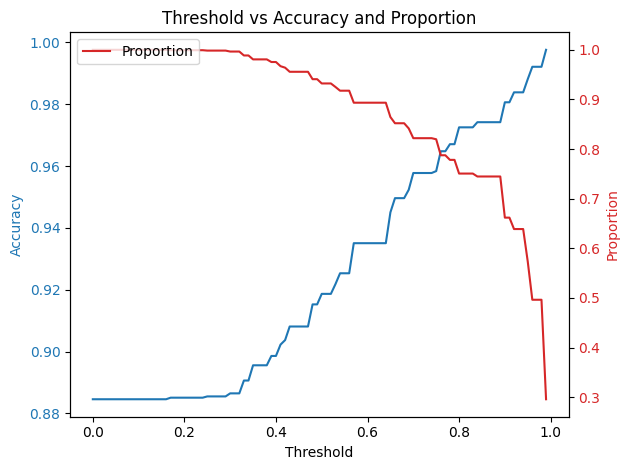

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_classification(data, threshold):
    """
    Calculates accuracy and proportion for a given threshold.

    Parameters:
    data (DataFrame): The dataset containing 'Confidence' and 'C' columns.
    threshold (float): The confidence threshold to filter the data.

    Returns:
    accuracy (float): The classification accuracy at the given threshold.
    proportion (float): The proportion of data above the threshold.
    """
    # Filter data based on threshold
    filtered_data = data[(data['Confidence'] >= threshold)]
    
    # Calculate correct classifications
    correct_data = filtered_data[data['C'] == True]
    
    # Calculate accuracy and proportion
    accuracy = len(correct_data) / len(filtered_data) if len(filtered_data) > 0 else 0
    proportion = len(filtered_data) / len(data) if len(data) > 0 else 0
    
    return accuracy, proportion

def plot_accuracy_vs_threshold(data):
    """
    Plots accuracy and proportion against the confidence threshold.

    Parameters:
    data (DataFrame): The dataset containing 'Confidence' and 'C' columns.
    """
    thresholds = np.arange(0.0, 1.0, 0.01)
    accuracies = []
    proportions = []
    
    # Loop through thresholds and calculate accuracy and proportion
    for threshold in thresholds:
        accuracy, proportion = calculate_classification(data, threshold)
        accuracies.append(accuracy)
        proportions.append(proportion)
    
    # Create the plot
    fig, ax1 = plt.subplots()

    # Plot accuracy on the left y-axis
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Accuracy', color='tab:blue')
    ax1.plot(thresholds, accuracies, color='tab:blue', label='Accuracy')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create a second y-axis to plot the proportion
    ax2 = ax1.twinx()
    ax2.set_ylabel('Proportion', color='tab:red')
    ax2.plot(thresholds, proportions, color='tab:red', label='Proportion')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Plot the y = x line for reference
    # ax1.plot(thresholds, thresholds, color='black', linestyle='--', label='y = x')

    # Show the plot
    plt.title('Threshold vs Accuracy and Proportion')
    fig.tight_layout()  # Adjust layout to prevent clipping
    plt.legend(loc='upper left')
    plt.show()

# Example usage:
# Assuming 'data_test' is your DataFrame with 'Confidence' and 'C' columns
plot_accuracy_vs_threshold(data_test)
